In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cantera as ct
import timeit
import progressbar
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs

Use Cantera to keep track of reactions, stoichiometry, and rates. We could populate the rates randomly if we wanted to later for random matrix theory. We can also use the automatic mechanism generator with Cantera, but dimension starts to get large

In [2]:
gas=ct.Solution('h2o2.cti')
Nmax=3
ns=gas.n_species
nr=gas.n_reactions
species=gas.species_names

Use a multiindex to specify number of molecules of each of the $n_s$ species, and map to an array index using base $N_{max}$ digits for each species. The vector space will thus be $({N_{max}})^{ns}$ dimensional.

In [3]:
def get_digit(number, n, base):
    if number - base**n < 0:
        return 0
    return number // base**n % base
def get_multiindex(index):
    return np.array([get_digit(index, n, Nmax) for n in range(ns)])
def get_rate (multiindex, rstoi, k, reaction):
    if reaction.reaction_type == 1: #bimolecular
        return k*np.product(multiindex**rstoi)
    else: #three body reactions
        ret=0
        for third_body in range(ns):
            rstoi2=rstoi
            rstoi2[third_body]+=1
            efficiency=reaction.default_efficiency
            if species[third_body] in reaction.efficiencies.keys():
                efficiency=reaction.efficiencies[species[third_body]]
            ret+=efficiency*k*np.product(multiindex**rstoi2)
        return ret
def get_index(nums):
    return int(np.sum(nums*Nmax**np.arange(ns)))

For each reaction, we need to set the matrix elements for each possible transition. We will have to loop through each row, since there will be nonzero elements on each row, but the nonzero elements in each row is limited to the number of reactions $n_r$. So this is $O(n_r({N_{max}})^{n_s})$ to populate the array. This could be parallelized.

In [7]:
data=[]
rows=[]
columns=[]
start=timeit.default_timer()
print("Percent\tElapsed\tRemaining")
for rind in range(nr):
    stop=timeit.default_timer()
#     print("%.3f\t%.2f\t%.2f"%((rind*1.0/(nr-1)), stop-start, (stop-start)*(nr-rind-1)*1.0/(1+rind)),end="\t\r")
    reaction=gas.reactions()[rind]
    k=gas.forward_rate_constants[rind]
    rstoi=np.array([reaction.reactants[x] if x in reaction.reactants.keys() else 0 for x in species])
    pstoi=np.array([reaction.products[x] if x in reaction.products.keys() else 0 for x in species])
    for  i in range(Nmax**ns):
        stop=timeit.default_timer()
        print("%.3f\t%.2f\t%.2f"%((rind*1.0/(nr-1)), stop-start, (stop-start)*(nr-rind-1)*1.0/(1+rind)),end="\t\r")
        multiindex=get_multiindex(i)
        gas.X=multiindex 
        k=gas.forward_rate_constants[rind]
        multiindex2=multiindex-rstoi+pstoi
        if np.all((multiindex-rstoi)[np.where(rstoi>0)]>=0) and np.all(multiindex2<Nmax):
            j=get_index(multiindex2)
            
            data.append(get_rate(multiindex,rstoi,k,reaction))
            rows.append(i)
            columns.append(j)
        k=gas.reverse_rate_constants[rind]
        multiindex2=multiindex+rstoi-pstoi
        if np.all((multiindex-pstoi)[np.where(pstoi>0)]>=0) and np.all(multiindex2<Nmax):
            j=get_index(multiindex2)
            data.append(get_rate(multiindex,pstoi,k,reaction))
            rows.append(i)
            columns.append(j)
            
print("%.3f\t%.2f\t%.2f"%((rind*1.0/(nr-1)), stop-start, (stop-start)*(nr-rind-1)*1.0/(1+rind)))
ratematrix=coo_matrix((np.array(data),(np.array(rows),np.array(columns))),(Nmax**ns,Nmax**ns))
print("Sparsity: %f"%(1-len(data)*1.0/(Nmax**(2*ns))))
print("Average non-zero entry: %f"%(np.mean(data)))

Percent	Elapsed	Remaining


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


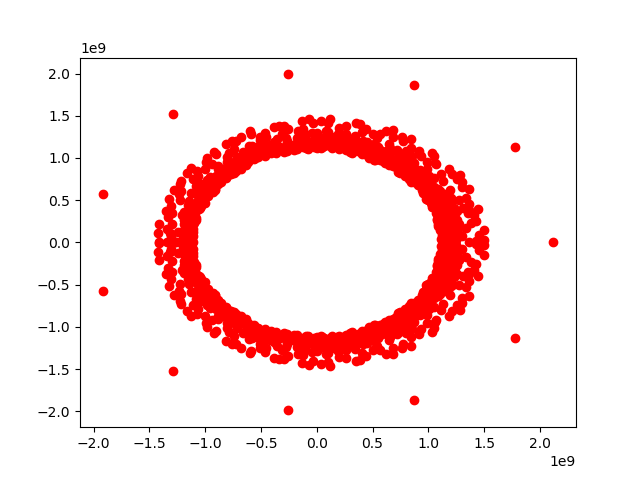

In [113]:
eigenvalues,eigenvectors=eigs(ratematrix,k=1000)
plt.plot(np.real(eigenvalues),np.imag(eigenvalues), 'ro')
plt.show()

In [8]:
nr

28

In [ ]:
27